# OpenML Impact Analysis

In [1]:
# !python3.12 -m venv venv

!pip install -r ../requirements.txt --quiet


[notice] A new release of pip is available: 23.2.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

## Data cleaning and preprocessing

In [3]:
# Load survey data

path1 = '../data/collected_papers.csv' # Original list of collected papers
path2 = "../data/Final_survey_data.csv" # Survey Results

df_survey_results = pd.read_csv(path2)

print("Total no of reviews recieved: ", len(df_survey_results))
df_survey_results.head()

Total no of reviews recieved:  1770


,Unnamed: 0,Timestamp,Paper ID (from shared sheet),Paper Title,Paper Year,Paper Available,Paper in English,Does the paper have at least 1 current OpenML Core Member as co-author?,"If yes, which Core Members?",Does the paper use datasets from OpenML?,...,Does the paper upload datasets to OpenML?,"If yes, which dataset?",Does the paper upload experiment data to OpenML?,"if yes: short (e.g., 1 sentence) explanation: what type of experiments?",Does the paper interact in any other way with OpenML?,"if yes: short (e.g., 1 sentence) explanation how?",Star it as some cool project to be showcased in our paper?,"If yes, please motivate your answer",Optional short description,"Is the paper a thesis (Bachelor's, Master's, or PhD)?"
0,1784,2025-05-17,593,Advances in Computational Intelligence: 16th I...,2021,No,Yes,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,2025-01-20 17:42:12,1236,Optimal or Greedy Decision Trees? Revisiting t...,2024,Yes,Yes,No,NaN,Yes,...,No,NaN,No,NaN,No,NaN,No,NaN,NaN,NaN
2,1,2025-01-21 10:38:07,675,Impact of sampling on learning asymmetric-entr...,2019,Yes,Yes,No,NaN,Yes,...,No,NaN,No,NaN,No,NaN,No,NaN,NaN,NaN
3,2,2025-01-21 13:41:44,1377,Efficient density and cluster based incrementa...,2022,Yes,Yes,No,NaN,Yes,...,No,NaN,No,NaN,No,NaN,No,NaN,NaN,NaN
4,3,2025-01-21 13:44:29,1597,Consensus driven on-device hyperparameter opti...,2024,Yes,Yes,No,NaN,Yes,...,No,NaN,No,NaN,No,NaN,No,NaN,NaN,NaN


In [4]:
pd.DataFrame(df_survey_results.columns)

,0
0,Unnamed: 0
1,Timestamp
2,Paper ID (from shared sheet)
3,Paper Title
4,Paper Year
5,Paper Available
6,Paper in English
7,Does the paper have at least 1 current OpenML ...
8,"If yes, which Core Members?"
9,Does the paper use datasets from OpenML?


### Sanity Check:
1. Find dublicates and remove duplicates (matched using Paper ID column).
2. Match paper ID and paper title from original list.
3. Remove papers with wrong year (<2014) 
4. Exclude papers from year =2025. 
5. Remove empty rows

In [5]:
Total_papers = pd.read_csv(path1) # Original list of scraped paper
print("Total number of scraped papers: ", len(Total_papers))

Total number of scraped papers:  1786


In [6]:
# Papers which not available or behind paywall
unvailable_papers = len(Total_papers) - len(df_survey_results)
print(unvailable_papers)

16


In [7]:
# Create a dictionary mapping Paper ID to Title from the original list. 
assigned_papers_dict = Total_papers[["Paper ID", "Title"]].set_index('Paper ID').to_dict()
assigned_papers_dict = assigned_papers_dict["Title"]
assigned_papers_dict

{177: 'Plaster: An Integration, Benchmark and Development Framework for Heterogeneous Metadata Normalization Methods',
 1404: 'On the predictive power of meta-features in OpenML',
 46: 'Probabilistic matrix factorization for automated machine learning',
 155: 'Challenges and opportunities of generative models on tabular data',
 1593: 'Interpretable machine learning for time-to-event prediction in medicine and healthcare',
 1234: 'Application of machine learning for fleet-based condition monitoring of ball screw drives in machine tools',
 1535: 'How data scientistswork together with domain experts in scientific collaborations: To find the right answer or to ask the right question?',
 1709: 'Open graph benchmark: Datasets for machine learning on graphs',
 573: 'On efficiently explaining graph-based classifiers',
 324: 'OpenML: a networked science platform for machine learning',
 1344: 'LBC: Language-Based-Classifier for Out-Of-Variable Generalization',
 290: 'Distributed hybrid quantum-c

In [8]:
sheet1 = Total_papers[["Paper ID", "openml-suites-2021", "openml-python-2021", "openml-2014", "openml-r-2017"]]
sheet1.rename(columns={"Paper ID": "Paper ID (from shared sheet)"}, inplace=True)
df_survey_results = df_survey_results.merge(sheet1, on="Paper ID (from shared sheet)", how="left")
df_survey_results.head()

/tmp/ipykernel_189826/512147997.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sheet1.rename(columns={"Paper ID": "Paper ID (from shared sheet)"}, inplace=True)


,Unnamed: 0,Timestamp,Paper ID (from shared sheet),Paper Title,Paper Year,Paper Available,Paper in English,Does the paper have at least 1 current OpenML Core Member as co-author?,"If yes, which Core Members?",Does the paper use datasets from OpenML?,...,Does the paper interact in any other way with OpenML?,"if yes: short (e.g., 1 sentence) explanation how?",Star it as some cool project to be showcased in our paper?,"If yes, please motivate your answer",Optional short description,"Is the paper a thesis (Bachelor's, Master's, or PhD)?",openml-suites-2021,openml-python-2021,openml-2014,openml-r-2017
0,1784,2025-05-17,593,Advances in Computational Intelligence: 16th I...,2021,No,Yes,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,False,False,True,False
1,0,2025-01-20 17:42:12,1236,Optimal or Greedy Decision Trees? Revisiting t...,2024,Yes,Yes,No,NaN,Yes,...,No,NaN,No,NaN,NaN,NaN,False,True,True,False
2,1,2025-01-21 10:38:07,675,Impact of sampling on learning asymmetric-entr...,2019,Yes,Yes,No,NaN,Yes,...,No,NaN,No,NaN,NaN,NaN,False,False,True,False
3,2,2025-01-21 13:41:44,1377,Efficient density and cluster based incrementa...,2022,Yes,Yes,No,NaN,Yes,...,No,NaN,No,NaN,NaN,NaN,False,False,True,False
4,3,2025-01-21 13:44:29,1597,Consensus driven on-device hyperparameter opti...,2024,Yes,Yes,No,NaN,Yes,...,No,NaN,No,NaN,NaN,NaN,False,False,True,False


In [ ]:
# Step 1: Remove Dublicates

# Duplicate entries
df_duplicate_rows = df_survey_results[df_survey_results.duplicated(subset=["Paper ID (from shared sheet)"], keep=False)]

print("No. of duplicates:", len(df_duplicate_rows))
df_duplicate_rows

No. of duplicates: 0


,Unnamed: 0,Timestamp,Paper ID (from shared sheet),Paper Title,Paper Year,Paper Available,Paper in English,Does the paper have at least 1 current OpenML Core Member as co-author?,"If yes, which Core Members?",Does the paper use datasets from OpenML?,...,Does the paper interact in any other way with OpenML?,"if yes: short (e.g., 1 sentence) explanation how?",Star it as some cool project to be showcased in our paper?,"If yes, please motivate your answer",Optional short description,"Is the paper a thesis (Bachelor's, Master's, or PhD)?",openml-suites-2021,openml-python-2021,openml-2014,openml-r-2017


In [ ]:
duplicates = df_survey_results[df_survey_results.duplicated(subset=["Paper ID (from shared sheet)"], keep=False)]
# Save duplicates to a separate DataFrame before removal
duplicates_removed = df_survey_results[df_survey_results.duplicated(subset=["Paper ID (from shared sheet)"], keep="first")]

df_survey_results = df_survey_results.drop_duplicates(subset=["Paper ID (from shared sheet)"], keep="first")

print("No of duplicates removed: ", len(duplicates_removed))
duplicates_removed.sort_values(by="Paper ID (from shared sheet)")

No of duplicates removed:  0


,Unnamed: 0,Timestamp,Paper ID (from shared sheet),Paper Title,Paper Year,Paper Available,Paper in English,Does the paper have at least 1 current OpenML Core Member as co-author?,"If yes, which Core Members?",Does the paper use datasets from OpenML?,...,Does the paper interact in any other way with OpenML?,"if yes: short (e.g., 1 sentence) explanation how?",Star it as some cool project to be showcased in our paper?,"If yes, please motivate your answer",Optional short description,"Is the paper a thesis (Bachelor's, Master's, or PhD)?",openml-suites-2021,openml-python-2021,openml-2014,openml-r-2017


In [11]:
print("No of reviews after duplicate removal: ", len(df_survey_results))

No of reviews after duplicate removal:  1770


In [12]:
# Step 2: Remove mismatches
# All entries where the paper title and paper ID in the survey does not match the title in the original list
# Create a DataFrame to store mismatches

mismatches = []

for index, row in df_survey_results.iterrows():
    try:
        paper_id = row["Paper ID (from shared sheet)"]
        paper_title = row["Paper Title"].strip().lower()
        assigned_title = assigned_papers_dict.get(paper_id).strip().lower()

        if paper_title not in assigned_title:
            mismatches.append({
                "Paper ID": paper_id,
                "Given Title": row["Paper Title"],
                "Expected Title": assigned_papers_dict.get(paper_id, "Not Found")
            })

    except Exception as e:
        mismatches.append({
            "Paper ID": row["Paper ID (from shared sheet)"],
            "Error": str(e),
            "Given Title": row.get("Paper Title", "Not Found")
        })
        continue

mismatches_df = pd.DataFrame(mismatches)
mismatches_df



,Paper ID,Given Title,Expected Title
0,1030,Convolutional neural networks for classificati...,Convolutional neural networks for classificati...
1,1246,Adapting TabPFN for Zero-Inflated Metagenomics...,Adapting TabPFN for Zero-Inflated Metagenomic ...
2,1458,AutoEn: An AutoML method based on ensembles of...,AutoEn: an AutoML method based on ensembles of...
3,26,Don’t Blindly Use Data: Towards a Data Stateme...,Don't Blindly Use Data: Towards a Data Stateme...
4,966,OpenML-Connect: A C++ connection library for O...,OpenML-Connect: A C++\nconnection library for ...
5,1397,MLPro — An integrative middleware framework fo...,MLPro-A synoptic framework for standardized ma...
6,123,D7.7 AutoAI Benchmarks v.3 Report,D7. 7 AutoAI Benchmarks v. 3 Report
7,267,out of distribution learning,OUT-OF-DISTRIBUTION LEARNING
8,1137,Projected Naïve Bayes,Projected naive bayes
9,1461,An Ensemble Model for 2D-data Classification b...,An Ensemble Model for 2D-data Classification b...


In [13]:
# No Mismatches between the paper title and paper ID

In [14]:
print("No of reviews after mismatch entry removal: ", len(df_survey_results))

No of reviews after mismatch entry removal:  1770


In [15]:
# Step 5: Drop rows with all NaN or NaT values
print(len(df_survey_results))
df_survey_results = df_survey_results.dropna(how="all")

print("no of reviews after empty row removal:", len(df_survey_results))

1770
no of reviews after empty row removal: 1770


In [ ]:
# Step 3 and 4: Remove papers with a year before 2014 and after 2024.
# Paper year before 2014 is an incorrect entry. 
# Paper year after 2024 are not considered in the survey.

# Convert to numeric, invalid strings become NaN
df_survey_results["Paper Year"] = pd.to_numeric(df_survey_results["Paper Year"], errors='coerce')

# Drop rows with NaN in 'Paper Year'
# This is because the paper is not available or behind paywall, so the paper year was not available.
df_survey_results = df_survey_results[df_survey_results["Paper Year"].notna()]


# Convert to integer 
df_survey_results["Paper Year"] = df_survey_results["Paper Year"].astype(int)
print(len(df_survey_results))

# # Check the updated column type
# print(df_survey_results["Paper Year"].dtypes)

unvailable_papers = unvailable_papers + (1770-len(df_survey_results))

# pepers with NaN or invalid entry type (not int) are unvalible (or being paywall)
print("unvailable_papers:", unvailable_papers)

1741
unvailable_papers: 45


In [17]:
# Print entries with year before 2014 or after 2024

out_of_range_2014 = df_survey_results[(df_survey_results["Paper Year"] < 2014)]

print("Papers with year before 2014:", len(out_of_range_2014))


out_of_range_2024 = df_survey_results[(df_survey_results["Paper Year"] >2024)]
print("Papers with year after 2025:", len(out_of_range_2024))
# print("Papers with year after 2025:", out_of_range_2024)

no_of_papers_before_out_of_year_removal = len(df_survey_results)

# Remove paper year before 2014 and after 2024
df_survey_results = df_survey_results[(df_survey_results["Paper Year"] >= 2014) & (df_survey_results["Paper Year"] <= 2024)]
no_of_papers_after_out_of_year_removal = len(df_survey_results)

print("No of papers after removal of papers (before 2014 and after 2025):", len(df_survey_results))

Papers with year before 2014: 0
Papers with year after 2025: 24
No of papers after removal of papers (before 2014 and after 2025): 1717


In [18]:
print("Papers removed (wrong year or after 2024): ", no_of_papers_before_out_of_year_removal - no_of_papers_after_out_of_year_removal)

Papers removed (wrong year or after 2024):  24


In [19]:
df_survey_results["Paper Available"].unique()

array(['No', 'Yes', 'Thesis without online PDF', 'Paywall',
       'No. Cannot find it anywhere for free.',
       'Paper with title not found',
       'only partial thesis (12 page preview) available.',
       'only thesis preview available',
       'No paper available, only citation.',
       'Links to the paper are dead, 404',
       'Not accessible anywhere (not reachable)',
       'springer paywall (also from faculty)', 'Thesis Porto, can obtain',
       'This is not a paper, but a presentation (slides) of a tutorial',
       'Composite PhD Thesis (of Core member). While this thesis does many cool things, it has an integral copy of all papers in it. Therefore, excluding it and referring to the individual papers',
       'Paywall (also from Uni IP)', nan, 'No (dead link)',
       'No (paywall)', 'yes', 'no'], dtype=object)

In [20]:
df_survey_results["Paper Available"] = df_survey_results["Paper Available"].astype(str).str.lower()

count_yes = df_survey_results["Paper Available"].value_counts().get("yes", 0)
print(count_yes)
print(len(df_survey_results)-count_yes)

unvailable_papers = unvailable_papers + (len(df_survey_results)-count_yes)
print("Total no of unvailable_papers:", unvailable_papers)


1578
139
Total no of unvailable_papers: 184


In [21]:
df_survey_results["Paper in English"] = df_survey_results["Paper in English"].astype(str).str.lower()

eng_count_yes = df_survey_results["Paper in English"].value_counts().get("yes", 0)
print(eng_count_yes)
print(len(df_survey_results)-count_yes)

1645
139


In [22]:
# No fo paper which are both not (completely) available and not in english
overlap = df_survey_results[(df_survey_results["Paper Available"] != "yes") & (df_survey_results["Paper in English"] != "yes")]
print(len(overlap))

22


In [23]:
# Filter rows not in final_df
not_in_final_df = df_survey_results[~((df_survey_results["Paper Available"] == "yes") &  (df_survey_results["Paper in English"] == "yes"))]

print(len(not_in_final_df))
# Display the rows not in final_df
not_in_final_df[["Paper Available", "Paper in English"]]


189


,Paper Available,Paper in English
0,no,yes
30,thesis without online pdf,nan
34,yes,no
39,paywall,nan
94,yes,no
...,...,...
1713,yes,paywall
1750,no,yes
1756,yes,no
1764,no,yes


In [24]:
# Should only consider paper available + in english
available_papers = df_survey_results[(df_survey_results["Paper Available"] == "yes") & (df_survey_results["Paper in English"] == "yes")].copy()
print("Final number of papers for analysis: ", len(available_papers))

Final number of papers for analysis:  1528


In [25]:
# convert all columns of str type to lower case

# Identify string columns
str_cols = available_papers.select_dtypes(include=["object", "string"]).columns
# print(str_cols)

# Convert all string columns to lowercase
for col in str_cols:
    available_papers[col] = available_papers[col].astype(str).str.lower()
    
available_papers.head()


,Unnamed: 0,Timestamp,Paper ID (from shared sheet),Paper Title,Paper Year,Paper Available,Paper in English,Does the paper have at least 1 current OpenML Core Member as co-author?,"If yes, which Core Members?",Does the paper use datasets from OpenML?,...,Does the paper interact in any other way with OpenML?,"if yes: short (e.g., 1 sentence) explanation how?",Star it as some cool project to be showcased in our paper?,"If yes, please motivate your answer",Optional short description,"Is the paper a thesis (Bachelor's, Master's, or PhD)?",openml-suites-2021,openml-python-2021,openml-2014,openml-r-2017
1,0,2025-01-20 17:42:12,1236,optimal or greedy decision trees? revisiting t...,2024,yes,yes,no,nan,yes,...,no,nan,no,nan,nan,nan,False,True,True,False
2,1,2025-01-21 10:38:07,675,impact of sampling on learning asymmetric-entr...,2019,yes,yes,no,nan,yes,...,no,nan,no,nan,nan,nan,False,False,True,False
3,2,2025-01-21 13:41:44,1377,efficient density and cluster based incrementa...,2022,yes,yes,no,nan,yes,...,no,nan,no,nan,nan,nan,False,False,True,False
4,3,2025-01-21 13:44:29,1597,consensus driven on-device hyperparameter opti...,2024,yes,yes,no,nan,yes,...,no,nan,no,nan,nan,nan,False,False,True,False
5,4,2025-01-21 13:49:29,273,model selection with bootstrap validation,2023,yes,yes,no,nan,yes,...,no,nan,no,nan,nan,nan,False,False,True,True


In [26]:
print("Final Statistics:")
print("1. Total no. papers initially identifier:", len(Total_papers))
print("2. Papers not fully available:", unvailable_papers)
print("3. Papers not in English and without available translations:", len(df_survey_results)-eng_count_yes)
print("4: Overlap (no of papers not available and not in English):", len(overlap))
print("5. Papers with year after 2024:", no_of_papers_before_out_of_year_removal - no_of_papers_after_out_of_year_removal)
print("6. Final papers analyzed:", len(available_papers))

# Verify the final number of available papers
# The final number of available papers should be equal to the total number of scraped papers minus:
# 1. The number of unavailable papers
# 2. The number of papers that are not in English
# 3. The number of papers that were removed due to being published in 2025
assert len(available_papers) == len(Total_papers) - (unvailable_papers + (len(df_survey_results)-eng_count_yes) - len(overlap)) - (no_of_papers_before_out_of_year_removal - no_of_papers_after_out_of_year_removal) 


Final Statistics:
1. Total no. papers initially identifier: 1786
2. Papers not fully available: 184
3. Papers not in English and without available translations: 72
4: Overlap (no of papers not available and not in English): 22
5. Papers with year after 2024: 24
6. Final papers analyzed: 1528


## Analysis

In [27]:

columns_to_analyze = ["openml-suites-2021", "openml-python-2021", "openml-2014", "openml-r-2017"]

# Calculate the percentage of True values for each column
percentages = available_papers[columns_to_analyze].mean() * 100

# Print the results
for column, percentage in percentages.items():
    print(f"Percentage of papers with True for {column}: {percentage:.2f}%")


Percentage of papers with True for openml-suites-2021: 8.44%
Percentage of papers with True for openml-python-2021: 5.56%
Percentage of papers with True for openml-2014: 90.38%
Percentage of papers with True for openml-r-2017: 3.66%


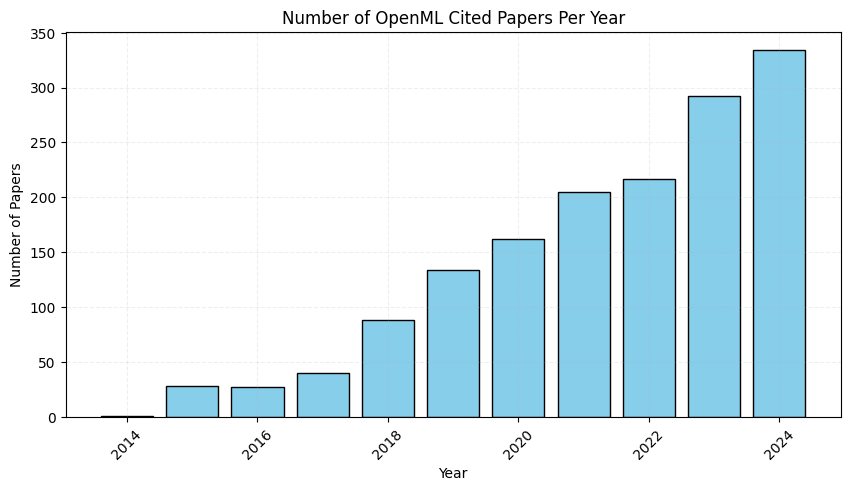

In [28]:

# Count the number of papers per year
papers_per_year = available_papers["Paper Year"].value_counts().sort_index()

plt.figure(figsize=(10, 5))
plt.bar(papers_per_year.index, papers_per_year.values, color="skyblue", edgecolor="black")

plt.xlabel("Year")
plt.ylabel("Number of Papers")
plt.title("Number of OpenML Cited Papers Per Year")
plt.xticks(rotation=45)
plt.grid(linestyle='--', alpha=0.2)

plt.show()


In [29]:
# What percentage of the papers does just cite OpenML, but not actively interact with it?

interaction_columns = [
    "Does the paper use datasets from OpenML?",
    "Does the paper use a collection (at least 2 or more) of datasets that are defined by OpenML designated to do benchmarking (e.g., openml benchmarking suites)?",
    "Does the paper use OpenML experiment data (i.e., utilise results from runs)? ",
    "Does the paper upload datasets to OpenML?",
    "Does the paper upload experiment data to OpenML?",
    "Does the paper interact in any other way with OpenML?"
]

just_citing_papers = available_papers[(available_papers[interaction_columns] == "no").all(axis=1)]

percentage_citing_only = (len(just_citing_papers) / len(available_papers)) * 100
print(len(just_citing_papers), round(percentage_citing_only, 2))

core_citing_papers = just_citing_papers[just_citing_papers["Does the paper have at least 1 current OpenML Core Member as co-author?"] == "yes"]
print(len(core_citing_papers), round((len(core_citing_papers)/len(just_citing_papers))*100,2))


319 20.88
23 7.21


In [30]:
# out of above papers which just cites openml, % of paper citing Openml-2014 paper

just_citing_openml_2014 = just_citing_papers[just_citing_papers["openml-2014"] == True]
print(len(just_citing_openml_2014), (len(just_citing_openml_2014) / len(just_citing_papers)) * 100)


296 92.78996865203762


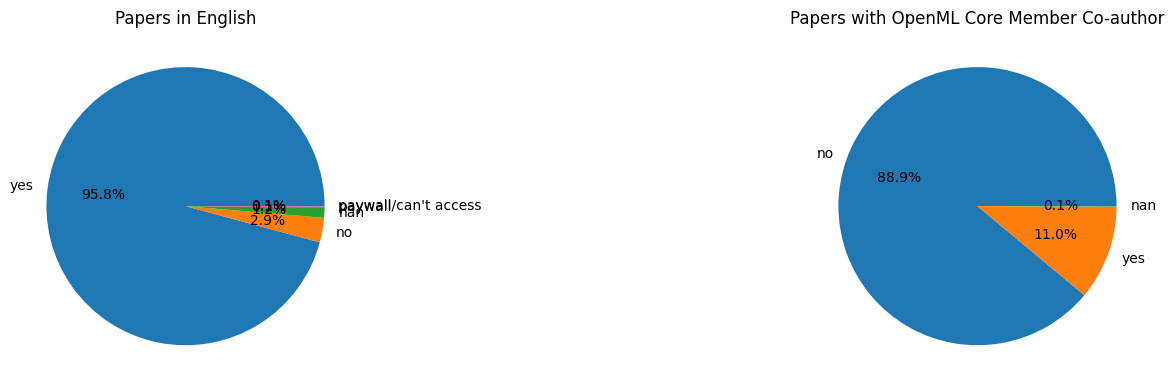

In [31]:
english_counts = df_survey_results["Paper in English"].value_counts()

plt.figure(figsize=(18, 4))

plt.subplot(1, 2, 1)
plt.pie(english_counts, labels=english_counts.index, autopct="%1.1f%%")
plt.title("Papers in English")


core_member_counts = available_papers["Does the paper have at least 1 current OpenML Core Member as co-author?"].value_counts()

plt.subplot(1, 2, 2)
plt.pie(core_member_counts, labels=core_member_counts.index, autopct="%1.1f%%")
plt.title("Papers with OpenML Core Member Co-author")

plt.tight_layout()
plt.show()

In [32]:
# Datasets

dataset_papers = available_papers[available_papers["Does the paper use datasets from OpenML?"] == "yes"]
dataset_percentage = (len(dataset_papers) / len(available_papers)) * 100
print(dataset_percentage, (len(dataset_papers)))
print("Number of paper by core-authors: ",len(dataset_papers[dataset_papers["Does the paper have at least 1 current OpenML Core Member as co-author?"] == "yes"]))

unclear_dataset_papers = available_papers.dropna(subset=["If unclear, one sentence explanation?"])
unclear_dataset_papers = unclear_dataset_papers[["Does the paper use datasets from OpenML?", "If unclear, one sentence explanation?"]]
unclear_dataset_papers

73.7565445026178 1127
Number of paper by core-authors:  124


,Does the paper use datasets from OpenML?,"If unclear, one sentence explanation?"
1,yes,nan
2,yes,nan
3,yes,nan
4,yes,nan
5,yes,nan
...,...,...
1763,no,nan
1765,yes,nan
1766,yes,nan
1767,yes,nan


In [44]:
# Benchmark
benchmark_papers = available_papers[available_papers["Does the paper use a collection (at least 2 or more) of datasets that are defined by OpenML designated to do benchmarking (e.g., openml benchmarking suites)?"] == "yes"]
benchmark_percentage = (len(benchmark_papers) / len(available_papers)) * 100
print(benchmark_percentage, len(benchmark_papers))

benchmark_datasets = benchmark_papers["If yes, which benchmark suites?"]

print("Number of paper by core-authors: ",len(benchmark_papers[benchmark_papers["Does the paper have at least 1 current OpenML Core Member as co-author?"] == "yes"]))
# Print list of benchmark datasets
unique_benchmark_datasets = (
    benchmark_datasets.str.lower().str.strip().unique()
)


unique_benchmark_datasets

12.696335078534032 194
Number of paper by core-authors:  54


array(['meta-learning study (details can be found on https://www.openml.org/s/7)',
       'automl benchmark version 1', 'openml-cc18',
       'not mentioned. "all datasets are classification problem from openml benchmark."',
       'openml cc-18 benchmarking suite ((excluding datasets 554, 40923, 40927, 40996 due to technical issues)',
       'openml100', 'openml100, openml-cc18 and automl benchmark',
       'openml cc-18', 'automl benchmark 2019 (gijsbers)',
       'automl benchmark 2019, gijsbers', 'openml-cc18; openml-automl',
       'openml100, openml-cc18', 'automl benchmark',
       'openml-ctr23, automl', 'openml cc18', 'the openml-cc18',
       'openml-cc18 benchmark', 'amlb', 'ctr23,cc18',
       'hyper-parameter tuning of support vector machines',
       'study 14, openml100', 'unclear', 'openml-cc18, amlb',
       'openml-cc18, openml100', 'cc18', 'ctr23', 'openml100, cc18',
       'id: 297, 300 (titles ambiguous)',
       'openml-cc18, automl benchmark more classification',

In [34]:
#  Experiment data (Runs)

experiment_papers = available_papers[available_papers["Does the paper use OpenML experiment data (i.e., utilise results from runs)? "] == "yes"]
experiment_percentage = (len(experiment_papers) / len(available_papers)) * 100

print(len(experiment_papers) ,experiment_percentage)
print("Number of paper by core-authors: ",len(experiment_papers[experiment_papers["Does the paper have at least 1 current OpenML Core Member as co-author?"] == "yes"]))


experiment_papers[["Paper ID (from shared sheet)", "if yes: short (e.g., 1 sentence) explanation: how does it use this data?"]]


66 4.319371727748691
Number of paper by core-authors:  19


,Paper ID (from shared sheet),"if yes: short (e.g., 1 sentence) explanation: how does it use this data?"
5,273,for benchmarking a model selection method
7,245,model evaluations are used for meta-learning
12,911,uses evaluation for a benchmark
17,910,algorithms / flows
84,364,meta-learning for bo
...,...,...
1550,1516,na
1577,1552,"pulls experiment data for meta analysis, but n..."
1606,1667,uses results from openml runs for comparison
1634,1641,openml metadata to study algorithm performance...


In [35]:
upload_datasets = available_papers[available_papers["Does the paper upload datasets to OpenML?"] == "yes"]

upload_datasets_percentage = len(upload_datasets) / len(available_papers) * 100

print( len(upload_datasets), upload_datasets_percentage)
print("Number of paper by core-authors: ",len(upload_datasets[upload_datasets["Does the paper have at least 1 current OpenML Core Member as co-author?"] == "yes"]))


upload_datasets[["Paper ID (from shared sheet)", "Does the paper upload datasets to OpenML?", "If yes, which dataset?"]]

23 1.5052356020942408
Number of paper by core-authors:  16


,Paper ID (from shared sheet),Does the paper upload datasets to OpenML?,"If yes, which dataset?"
108,506,yes,"unclear which dataset, but ""the datasets [...]..."
163,262,yes,meta-datasets based on a bayesian network gene...
187,745,yes,nan
196,1229,yes,nan
236,1421,yes,nan
246,1468,yes,75 datasets uploaded
275,672,yes,qsar datasets
367,538,yes,21 datasets collected from studies in the lite...
426,207,yes,nan
429,1566,yes,anomaly detection datasets created from synthe...


In [36]:
upload_experiment_data_papers = available_papers[available_papers["Does the paper upload experiment data to OpenML?"] == "yes"]

upload_experiment_data_percentage = len(upload_experiment_data_papers) / len(available_papers) * 100

print(len(upload_experiment_data_papers),upload_experiment_data_percentage)
print("Number of paper by core-authors: ",len(upload_experiment_data_papers[upload_experiment_data_papers["Does the paper have at least 1 current OpenML Core Member as co-author?"] == "yes"]))

upload_experiment_data_papers[["Paper ID (from shared sheet)", "if yes: short (e.g., 1 sentence) explanation: what type of experiments?"]]

27 1.7670157068062828
Number of paper by core-authors:  20


,Paper ID (from shared sheet),"if yes: short (e.g., 1 sentence) explanation: what type of experiments?"
22,507,accuracy of bagging stable classifiers in the ...
85,1484,a large-scale benchmarking study based on 38 d...
108,506,algorithm selection for classifiers
143,1301,324 runs on classification tasks ( datasets x ...
158,1111,"sample a task, a ml algorithm and hyperparamer..."
163,262,more than 1000 experiments on data streams.
187,745,nan
236,1421,nan
275,672,results from multi-task learning on qsar data...
329,1201,amlb benchmark


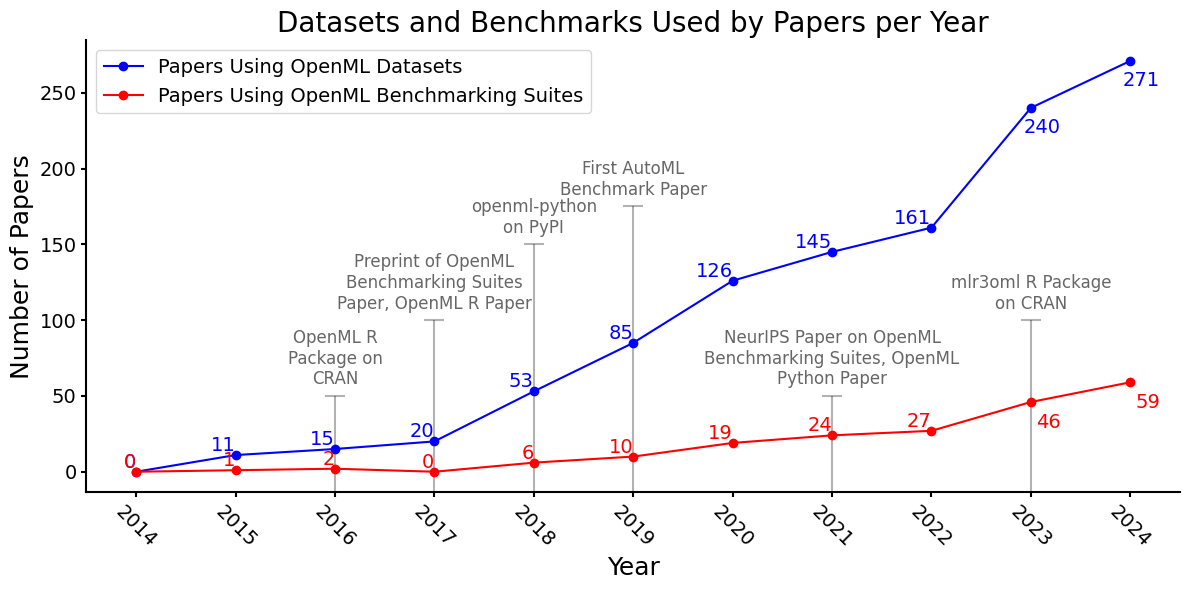

In [ ]:

available_papers["Datasets Used"] = available_papers["Does the paper use datasets from OpenML?"] == "yes"
available_papers["Benchmark Used"] = available_papers["Does the paper use a collection (at least 2 or more) of datasets that are defined by OpenML designated to do benchmarking (e.g., openml benchmarking suites)?"] == "yes"

# Group data by year for visualization
datasets_by_year = available_papers.groupby("Paper Year")["Datasets Used"].sum()
benchmarks_by_year = available_papers.groupby("Paper Year")["Benchmark Used"].sum()

# Filter out the year 2025
datasets_by_year_filtered = datasets_by_year[datasets_by_year.index != 2025]
benchmarks_by_year_filtered = benchmarks_by_year[benchmarks_by_year.index != 2025]

# Font sizes
LABEL_SIZE, TITLE_SIZE, NUMBER_SIZE = 14, 20, 14

def add_data_labels(ax, years, values, color):
    """Helper function to add data labels with consistent formatting"""
    for year, value in zip(years, values):
        if year >= 2023:
            va_alignment = 'top'
            y_offset, x_offset = -7, 0.3
        else:
            va_alignment = 'bottom'
            y_offset, x_offset = 0, 0

        ax.text(year + x_offset, value + y_offset, str(value),
                color=color, fontsize=NUMBER_SIZE,
                ha="right", va=va_alignment)

# Create figure and set padding
fig, ax = plt.subplots(figsize=(12, 6))
y_max = max(datasets_by_year_filtered.max(), benchmarks_by_year_filtered.max())
padding_factor = 1.05
ax.set_ylim(-(y_max * padding_factor - y_max), y_max * padding_factor)

# Define and add annotations
annotations = {
    2016: {"text": "OpenML R\nPackage on\nCRAN", "y_pos": 50},
    2017: {"text": "Preprint of OpenML\nBenchmarking Suites\nPaper, OpenML R Paper", "y_pos": 100},
    2018: {"text": "openml-python\non PyPI", "y_pos": 150},
    2019: {"text": "First AutoML\nBenchmark Paper", "y_pos": 175},
    2021: {"text": "NeurIPS Paper on OpenML\nBenchmarking Suites, OpenML\nPython Paper", "y_pos": 50},
    2023: {"text": "mlr3oml R Package\non CRAN", "y_pos": 100}
}

for year, anno_dict in annotations.items():
    y_pos = anno_dict["y_pos"]
    ax.vlines(x=year, ymin=ax.get_ylim()[0], ymax=y_pos, colors='black', alpha=.3)
    ax.hlines(y=y_pos, xmin=year-0.1, xmax=year+0.1, colors='black', alpha=.3)
    ax.text(year, y_pos + 5, anno_dict["text"],
            ha='center', va='bottom', fontsize=12,
            color='black', alpha=.6)

# Plot lines and add data labels
for data, color, label in [
    (datasets_by_year_filtered, 'blue', "Papers Using OpenML Datasets"),
    (benchmarks_by_year_filtered, 'red', "Papers Using OpenML Benchmarking Suites")
]:
    ax.plot(data.index, data.values, color=color, marker="o", label=label)
    add_data_labels(ax, data.index, data.values, color)

# Style the axes
all_years = range(min(datasets_by_year.index), max(datasets_by_year.index) + 1)
ax.set_xticks(all_years)
ax.set_xticklabels(all_years,rotation=-45)
ax.tick_params(axis='both', which='major', labelsize=LABEL_SIZE, width=1.5)
for spine in ax.spines.values():
    spine.set_linewidth(1.5)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Add labels and grid
ax.set_xlabel("Year", fontsize=18)
ax.set_ylabel("Number of Papers", fontsize=18)
ax.set_title("Datasets and Benchmarks Used by Papers per Year", fontsize=TITLE_SIZE)
ax.legend(fontsize=14)
#ax.grid(True, linestyle="--", alpha=0.6)

plt.tight_layout()
plt.show()

# Save figure
with PdfPages("Datasets_and_Benchmark_per_year.pdf") as fh:
    fh.savefig(fig, bbox_inches="tight")

In [39]:
other_interactions = available_papers[available_papers["Does the paper interact in any other way with OpenML?"] == "yes"]

other_interactions_percentage = len(other_interactions) / len(available_papers) * 100

print(len(other_interactions) , other_interactions_percentage)
print("Number of paper by core-authors: ",len(other_interactions[other_interactions["Does the paper have at least 1 current OpenML Core Member as co-author?"] == "yes"]))


other_interactions[["Does the paper interact in any other way with OpenML?", "if yes: short (e.g., 1 sentence) explanation how?"]]

88 5.7591623036649215
Number of paper by core-authors:  25


,Does the paper interact in any other way with OpenML?,"if yes: short (e.g., 1 sentence) explanation how?"
6,yes,ui for openml
17,yes,weird/interesting use case for rl
24,yes,creates openml task with id 167147
27,yes,openml is referenced as a platform that suppor...
28,yes,doesn't use any resource. mentions results fro...
...,...,...
1500,yes,conducts meta-learning analysis using openml p...
1600,yes,the paper describes an open-source python tool...
1708,yes,reuses and extends meta-data schema
1727,yes,discusses absence of computational resources f...


In [40]:
# Unique papers which are starred for special mention
starred_papers = available_papers[available_papers["Star it as some cool project to be showcased in our paper?"] == "yes"]

print(len(starred_papers))

starred_papers[["Paper ID (from shared sheet)", "If yes, please motivate your answer"]]


22


,Paper ID (from shared sheet),"If yes, please motivate your answer"
11,42,"auto-sklearn 2, milestone in automl research"
54,1343,converts a set of experiments from openml into...
85,1484,might be interesting! large scale hyperparamet...
137,1041,"might be interesting, showing the value of usi..."
158,1111,openml bot - interesting. but maybe another pa...
320,1116,the paper is accepted in vldb and uses openml ...
329,1201,its amlb
359,698,building a knowledge graph from openml's data ...
462,798,nan
538,1554,meta-learning (algorithm selection) system tha...


In [41]:
# output_file = "starred_papers.csv"
# starred_papers.to_csv(output_file, index=False)

In [42]:
thesis_papers = available_papers[available_papers["Is the paper a thesis (Bachelor's, Master's, or PhD)?"] == "yes"]

# Also, check for any occurrence of the word 'thesis' in the "Optional short description"
thesis_keyword_papers = available_papers[available_papers["Optional short description"].str.contains("thesis", case=False, na=False)]
all_thesis_papers = pd.concat([thesis_papers, thesis_keyword_papers]).drop_duplicates()


thesis_percentage = len(all_thesis_papers) / len(available_papers) * 100
print("Number of thesis supervised by core-authors: ",len(all_thesis_papers[all_thesis_papers["Does the paper have at least 1 current OpenML Core Member as co-author?"] == "yes"]))

print(len(all_thesis_papers), thesis_percentage)

Number of thesis supervised by core-authors:  11
202 13.219895287958114
